In [1]:
# ────────────────────────────────
# Step 1 – read the curve parameters
# ────────────────────────────────
import json, pprint

with open("results.json", "r") as f:
    CURVES = json.load(f)             # dict keyed by bit-size (strings)

load('generate_curve.sage')
print("Loaded curves:")
pprint.pprint(CURVES.keys())

Searching for a 128-bit prime-order curve …
[SEA runs: 50, candidates tested: 50]
✔ Found curve after SEA runs: 63, candidates tested: 63
Generation complete in 12.89 s
Candidates tested: 63
SEA executions: 63
p  = 285969967976617499852397384710772819859
a  = 162473434835985830153527433793718506495
b  = 180288992616607414104086326149539666778
#E = 285969967976617499836460964450890626241
G  = (82055903321077010240309441256896273768, 232203623477370466636698452880336490254)
Loaded curves:
dict_keys(['32', '40', '48'])


In [2]:
# ────────────────────────────────
# Step 2 – read the private keys
# ────────────────────────────────
with open("ecdh_results.json", "r") as f:
    KEY_DATA = json.load(f)           # list of dicts

PRIV = {entry["bit_size"]: entry for entry in KEY_DATA}

print("Bit-sizes with key-material:", sorted(PRIV))


Bit-sizes with key-material: [32, 40, 48]


In [3]:
# ───────────────────────────────────────────────────────
# Step 3 – build curves & generator, compute public keys
#                 + verify shared secrets
# ───────────────────────────────────────────────────────
from sage.all import EllipticCurve, GF

PUBLIC   = {}        # keeps E, G, A_pub, B_pub per bit-size

for bits, params in CURVES.items():
    b = int(bits)                       # Sage likes ints for dict keys

    # Curve & generator
    p, a, b_coef, n = params["p"], params["a"], params["b"], params["n"]
    Gx, Gy          = params["G_xy"]
    E  = EllipticCurve(GF(p), [a, b_coef])
    G  = E(Gx, Gy)

    # Private keys
    kA = PRIV[b]["alice_priv"]
    kB = PRIV[b]["bob_priv"]

    # Public keys
    A_pub = kA * G
    B_pub = kB * G

    PUBLIC[b] = dict(E=E, G=G, A=A_pub, B=B_pub)

print("✓ Public keys computed.")


✓ Public keys computed.


In [5]:
# ──────────────────────────────────────────────────────────
# Step 3.5 – generate fresh prime-order curves (32–44 bits)
#             and set up key-material for benchmarking
#             (uses generate_prime_order_curve)
# ──────────────────────────────────────────────────────────
from sage.all import randint

EXTRA_BITS = [32, 34, 36, 38, 40, 42, 44]

for bits in EXTRA_BITS:
    key = str(bits)
    print(f"→ Generating {bits}-bit prime-order curve…")
    # ➊ Call the generator
    E, G, candidates, sea_runs, gen_time = generate_prime_order_curve(bits)
    # ➋ Extract parameters
    p = E.base_field().order()
    a = E.a4()
    b = E.a6()
    n = E.cardinality()
    Gx, Gy = G.xy()
    # ➌ Store in CURVES dict (to mirror results.json structure)
    CURVES[key] = {
        "p": int(p),
        "a": int(a),
        "b": int(b),
        "n": int(n),
        "G_xy": [int(Gx), int(Gy)],
        "candidates": candidates,
        "sea_runs": sea_runs,
        "gen_time": gen_time
    }
    # ➍ Generate random key pairs for benchmarking
    kA = randint(1, n - 1)
    kB = randint(1, n - 1)
    PRIV[bits] = {
        "bit_size":    bits,
        "alice_priv":  int(kA),
        "bob_priv":    int(kB),
        "shared_secret": (kA * kB * G).xy()
    }
    # ➎ Prepare PUBLIC dict for Step 4
    PUBLIC[bits] = {
        "E": E,
        "G": G,
        "A": kA * G,
        "B": kB * G
    }

print("✓ Extra curves generated and ready for benchmarking:", EXTRA_BITS)


→ Generating 32-bit prime-order curve…
✔ Found curve after SEA runs: 19, candidates tested: 19
→ Generating 34-bit prime-order curve…
✔ Found curve after SEA runs: 28, candidates tested: 28
→ Generating 36-bit prime-order curve…
✔ Found curve after SEA runs: 44, candidates tested: 44
→ Generating 38-bit prime-order curve…
[SEA runs: 50, candidates tested: 50]
✔ Found curve after SEA runs: 85, candidates tested: 85
→ Generating 40-bit prime-order curve…
✔ Found curve after SEA runs: 29, candidates tested: 29
→ Generating 42-bit prime-order curve…
[SEA runs: 50, candidates tested: 50]
[SEA runs: 100, candidates tested: 100]
✔ Found curve after SEA runs: 144, candidates tested: 144
→ Generating 44-bit prime-order curve…
✔ Found curve after SEA runs: 36, candidates tested: 36
✓ Extra curves generated and ready for benchmarking: [32, 34, 36, 38, 40, 42, 44]


In [6]:
# ──────────────────────────────────────────────────────────
# Step 4 – solve ECDLP on newly generated curves only
# ──────────────────────────────────────────────────────────
from sage.groups.generic import discrete_log
import time

DL_TIMES = {}

# Only benchmark the curves we generated in Step 3.5
for bits in EXTRA_BITS:
    if bits not in PUBLIC:
        continue

    E, G, B = PUBLIC[bits]["E"], PUBLIC[bits]["G"], PUBLIC[bits]["B"]
    n       = CURVES[str(bits)]["n"]

    # Pollard’s ρ
    t0     = time.time()
    k_rho  = discrete_log(B, G, n, operation='+', algorithm='rho')
    rho_t  = time.time() - t0

    # Baby-Step Giant-Step
    t0      = time.time()
    k_bsgs  = discrete_log(B, G, n, operation='+', algorithm='bsgs')
    bsgs_t  = time.time() - t0

    # Record and display
    DL_TIMES[bits] = {"rho": rho_t, "bsgs": bsgs_t}
    print(f"{bits}-bit │ ρ: {rho_t:.4f}s   BSGS: {bsgs_t:.4f}s")

print("\n✓ Secret keys recovered and timings recorded for newly generated curves.")



32-bit │ ρ: 5.2319s   BSGS: 3.1047s
34-bit │ ρ: 1.9689s   BSGS: 4.4830s
36-bit │ ρ: 10.2339s   BSGS: 10.8325s
38-bit │ ρ: 32.2866s   BSGS: 17.9648s
40-bit │ ρ: 68.7362s   BSGS: 45.7544s
42-bit │ ρ: 92.5935s   BSGS: 54.5118s
44-bit │ ρ: 209.3457s   BSGS: 135.5784s

✓ Secret keys recovered and timings recorded for newly generated curves.


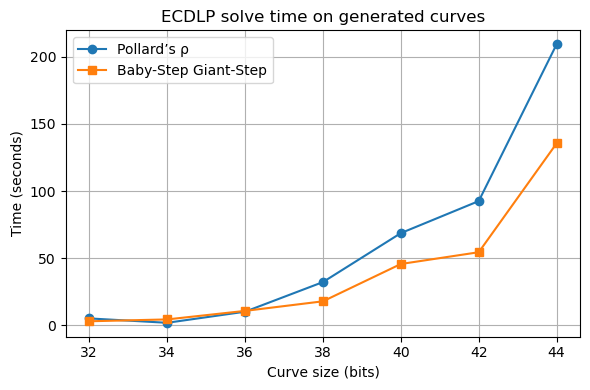

In [8]:
# ──────────────────────────────────────────────────────────
# Step 5 – plot benchmarks for newly generated curves only
# ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Use only the bit sizes we generated
bits = [b for b in EXTRA_BITS if b in DL_TIMES]
bits.sort()

rho_times  = [DL_TIMES[b]["rho"]  for b in bits]
bsgs_times = [DL_TIMES[b]["bsgs"] for b in bits]

plt.figure(figsize=(6,4))
plt.plot(bits, rho_times,  "o-", label="Pollard’s ρ")
plt.plot(bits, bsgs_times, "s-", label="Baby-Step Giant-Step")
plt.xlabel("Curve size (bits)")
plt.ylabel("Time (seconds)")
plt.title("ECDLP solve time on generated curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("ecdlp_generated_benchmarks.png", dpi=300)
plt.show()
